## First easy example of convolution

In [1]:
using Images, TestImages, PyPlot, BenchmarkTools

INFO: Recompiling stale cache file /Users/davidbuchaca1/.julia/lib/v0.6/StatsBase.ji for module StatsBase.
INFO: Recompiling stale cache file /Users/davidbuchaca1/.julia/lib/v0.6/ColorVectorSpace.ji for module ColorVectorSpace.
INFO: Recompiling stale cache file /Users/davidbuchaca1/.julia/lib/v0.6/Images.ji for module Images.


In [2]:
img = testimage("lena_gray");
img1 = Gray.(img);

INFO: Recompiling stale cache file /Users/davidbuchaca1/.julia/lib/v0.6/QuartzImageIO.ji for module QuartzImageIO.


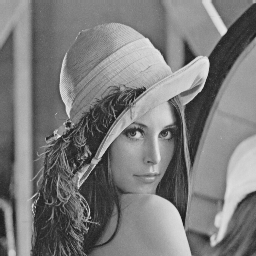

In [3]:
img1

In [4]:
size(img1)

(256, 256)

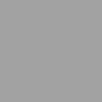

In [5]:
img1[1:3,1:3]

#### Apply Kernel

Let us consider the kernel 

```
1 0 -1
1 0 -1
1 0 -1
```

We would like to apply it at every possible position in the image. 

This mask is overlapped into the original image and the elementwise product of the values is computed.
Then it is added to get the value of the output.



In [6]:
K = [[1,1,1]  [0,0,0]  [-1,-1,-1]]

3×3 Array{Int64,2}:
 1  0  -1
 1  0  -1
 1  0  -1

In [7]:
X = Float32.(img1);

In [8]:
# This is the value that has to go to the Out[1,1]
sum(X[1:3,1:3].*K)

-1.1920929f-7

In [9]:
# This is the value that has to go to the Out[1,2]
sum(X[2:4,2:4].*K)

0.007843137f0

In [10]:
function convolution_2d_1(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    
    output = zeros(im_width-f, im_height-f)
    for w in 1:im_width-f
        for h in 1:im_height-f
            output[w,h] = sum(X[w:w+f-1, h:h+f-1] .* K)
        end
    end
    
    return output
end

convolution_2d_1 (generic function with 1 method)

In [11]:
@time Xconv = convolution_2d_1(X,K);

  0.083473 seconds (301.05 k allocations: 21.878 MiB, 6.29% gc time)


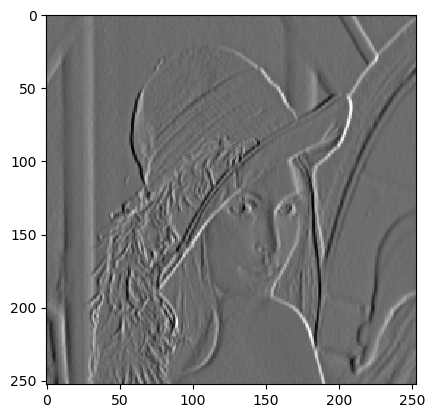

PyObject <matplotlib.image.AxesImage object at 0x12a195a10>

In [12]:
PyPlot.imshow(Xconv, cmap="gray")

In [13]:
@benchmark convolution_2d_1(X,K)

BenchmarkTools.Trial: 
  memory estimate:  20.02 MiB
  allocs estimate:  256038
  --------------
  minimum time:     6.010 ms (0.00% GC)
  median time:      7.674 ms (17.68% GC)
  mean time:        7.659 ms (16.56% GC)
  maximum time:     10.731 ms (18.52% GC)
  --------------
  samples:          653
  evals/sample:     1

### Improving speed Using views

In [14]:
function convolution_2d_2(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    
    output = zeros(im_width-f, im_height-f)
    for w in 1:im_width-f
        for h in 1:im_height-f
            output[w,h] = sum(view(X,w:w+f-1, h:h+f-1) .* K)
        end
    end
    
    return output
end

convolution_2d_2 (generic function with 1 method)

In [15]:
@benchmark convolution_2d_2(X,K)

BenchmarkTools.Trial: 
  memory estimate:  8.30 MiB
  allocs estimate:  64011
  --------------
  minimum time:     3.254 ms (0.00% GC)
  median time:      3.553 ms (0.00% GC)
  mean time:        3.790 ms (8.49% GC)
  maximum time:     5.975 ms (23.40% GC)
  --------------
  samples:          1317
  evals/sample:     1

In [16]:
Xconv2 = convolution_2d_2(X,K);

In [17]:
Xconv == Xconv2

true

### Change `X[w:w+f-1, h:h+f-1] .* K` by a double for loop


In [18]:
w = 10
h = 1
f = 3
K

3×3 Array{Int64,2}:
 1  0  -1
 1  0  -1
 1  0  -1

In [19]:
X[w:w+f-1, h:h+f-1]

3×3 Array{Float32,2}:
 0.615686  0.623529  0.619608
 0.611765  0.607843  0.607843
 0.623529  0.607843  0.6     

In [20]:
print(X[w,h],  "\t", X[w+1,h],   "\t", X[w+2,h],"\n")
print(X[w,h+1],"\t", X[w+1,h+1], "\t", X[w+2,h+1],"\n")
print(X[w,h+2],"\t", X[w+1,h+2], "\t", X[w+2,h+2] )

0.6156863	0.6117647	0.62352943
0.62352943	0.60784316	0.60784316
0.61960787	0.60784316	0.6

In [21]:
K

3×3 Array{Int64,2}:
 1  0  -1
 1  0  -1
 1  0  -1

In [22]:
aux = 0.
l = 1

for col in h:h+f-1
    for row in w:w+f-1
    #println("w",w)
        #println("row: ", row, "\tcol: ", col, "\t ", X[row,col])
        println("X[$row, $col] = ", X[row,col], "  \tK[$l] = ",K[l])
        aux += X[row,col]*K[l]
        l +=1
    end
end

X[10, 1] = 0.6156863  	K[1] = 1
X[11, 1] = 0.6117647  	K[2] = 1
X[12, 1] = 0.62352943  	K[3] = 1
X[10, 2] = 0.62352943  	K[4] = 0
X[11, 2] = 0.60784316  	K[5] = 0
X[12, 2] = 0.60784316  	K[6] = 0
X[10, 3] = 0.61960787  	K[7] = -1
X[11, 3] = 0.60784316  	K[8] = -1
X[12, 3] = 0.6  	K[9] = -1


In [23]:
aux

0.023529410362243652

In [24]:
sum(X[w:w+f-1, h:h+f-1] .*K) == aux

true

#### Write a function

In [25]:
function convolution_2d_3(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    
    output = zeros(im_width-f, im_height-f)
    for w in 1:im_width-f
        for h in 1:im_height-f
            aux = 0.
            l = 1
            for col in h:h+f-1
                for row in w:w+f-1
                    aux += X[row,col]*K[l]
                    l +=1
                end
            end
            output[w,h] = aux
        end
    end
    
    return output

end

convolution_2d_3 (generic function with 1 method)

In [26]:
Xconv3 = convolution_2d_3(X,K);

In [27]:
@benchmark convolution_2d_3(X,K)

BenchmarkTools.Trial: 
  memory estimate:  500.20 KiB
  allocs estimate:  2
  --------------
  minimum time:     767.365 μs (0.00% GC)
  median time:      924.763 μs (0.00% GC)
  mean time:        948.357 μs (3.15% GC)
  maximum time:     7.164 ms (0.00% GC)
  --------------
  samples:          5243
  evals/sample:     1

In [28]:
sum(Xconv3 .- Xconv)

-6.796419620513916e-5

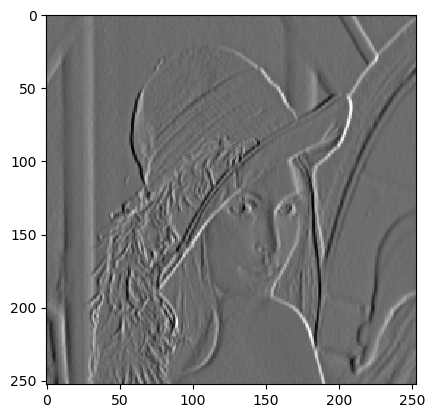

PyObject <matplotlib.image.AxesImage object at 0x10c36f210>

In [29]:
PyPlot.imshow(Xconv3, cmap="gray")

### Inbounds

In [259]:
function convolution_2d_4(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    output = zeros(eltype(X), im_width-f, im_height-f)
    @inbounds  for w in 1:im_width-f
        for h in 1:im_height-f
            aux = 0.
            l = 1
            for col in h:h+f-1
                for row in w:w+f-1
                    aux += X[row,col]*K[l]
                    l +=1
                end
            end
            output[w,h] = aux
        end
    end
    return output
end

convolution_2d_4 (generic function with 1 method)

In [260]:
Xconv4 = convolution_2d_4(X,K);

In [261]:
@benchmark convolution_2d_4(X,K)

BenchmarkTools.Trial: 
  memory estimate:  250.14 KiB
  allocs estimate:  2
  --------------
  minimum time:     558.155 μs (0.00% GC)
  median time:      637.292 μs (0.00% GC)
  mean time:        657.073 μs (3.44% GC)
  maximum time:     2.936 ms (75.96% GC)
  --------------
  samples:          7575
  evals/sample:     1

In [33]:
sum(Xconv3 .- Xconv)

-6.796419620513916e-5

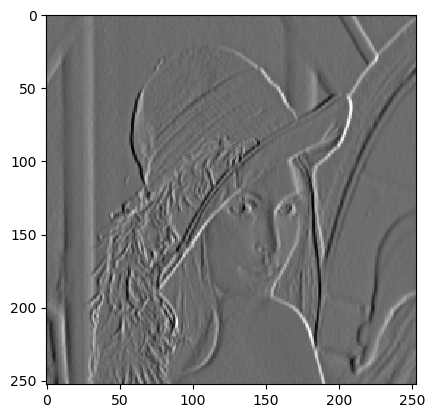

PyObject <matplotlib.image.AxesImage object at 0x1374010d0>

In [248]:
PyPlot.imshow(Xconv4, cmap="gray")

## Can we use simd units?

This might be tricky since the kernel itself

In [249]:
function convolution_2d_5(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    output = zeros(eltype(X), im_width-f, im_height-f)
    @inbounds  for w in 1:im_width-f
        for h in 1:im_height-f
            aux = 0.
            l = 1
            for col in h:h+f-1
                for row in w:w+f-1
                    aux += X[row,col]*K[l]
                    l +=1
                end
            end
            output[w,h] = aux
        end
    end
    return output
end

convolution_2d_5 (generic function with 1 method)

## Make kernel as static array

In [134]:
using StaticArrays

In [230]:
function convolution_2d_6(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    output = zeros(eltype(X), im_width-f, im_height-f)
    @inbounds  for w in 1:im_width-f
        for h in 1:im_height-f
            aux = 0.
            l = 1
            for col in h:h+f-1
                for row in w:w+f-1
                    aux += X[row,col]*K[l]
                    l +=1
                end
            end
            output[w,h] = aux
        end
    end
    return output
end

convolution_2d_5 (generic function with 1 method)

In [231]:
Ks = SMatrix{3,3,Float32}(1, 1, 1, 0, 0,0, -1,-1,-1) # flat, column-major storage, equal to m2:

3×3 StaticArrays.SArray{Tuple{3,3},Float32,2,9}:
 1.0  0.0  -1.0
 1.0  0.0  -1.0
 1.0  0.0  -1.0

In [232]:
Xconv5 = convolution_2d_6(X,Ks);

In [238]:
@benchmark convolution_2d_6(X, Ks)

BenchmarkTools.Trial: 
  memory estimate:  250.14 KiB
  allocs estimate:  2
  --------------
  minimum time:     480.124 μs (0.00% GC)
  median time:      556.779 μs (0.00% GC)
  mean time:        573.592 μs (3.83% GC)
  maximum time:     2.854 ms (73.62% GC)
  --------------
  samples:          8672
  evals/sample:     1

# Benchmark vs `Images.imfilter`

In [123]:
f = centered([[1,1,1]  [0,0,0]  [-1,-1,-1]])

OffsetArrays.OffsetArray{Int64,2,Array{Int64,2}} with indices -1:1×-1:1:
 1  0  -1
 1  0  -1
 1  0  -1

  0.000977 seconds (133 allocations: 555.609 KiB)


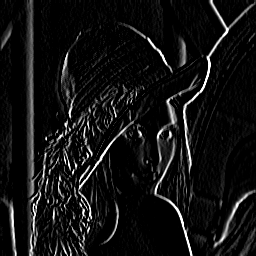

In [126]:
@time gx = imfilter(img, f)

In [128]:
@benchmark imfilter(img, f)

BenchmarkTools.Trial: 
  memory estimate:  555.45 KiB
  allocs estimate:  129
  --------------
  minimum time:     777.219 μs (0.00% GC)
  median time:      970.678 μs (0.00% GC)
  mean time:        1.001 ms (4.99% GC)
  maximum time:     3.314 ms (65.95% GC)
  --------------
  samples:          4979
  evals/sample:     1

In [129]:
Xconv4_imfilter = Float32.(gx[1:end-3,1:end-3]);

In [130]:
size(Xconv4), size(Xconv4_imfilter)

((253, 253), (253, 253))

In [131]:
# Why is this not the same?
isapprox(Xconv4_imfilter, Xconv4)

false

In [132]:
sum(Xconv4_imfilter - Xconv4)

-2.3450842f0

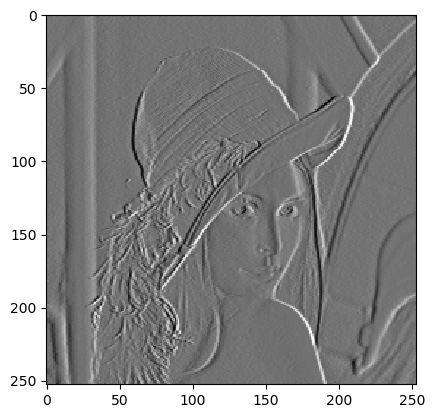

PyObject <matplotlib.image.AxesImage object at 0x130fe8850>

In [112]:
PyPlot.imshow(Xconv4_imfilter, cmap="gray")

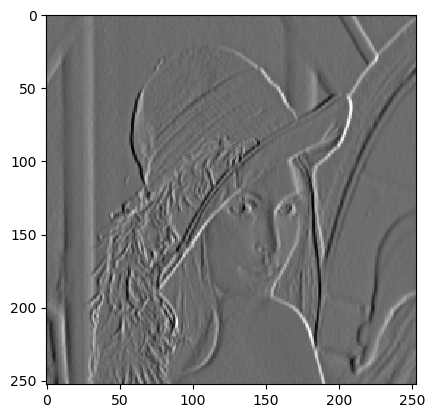

PyObject <matplotlib.image.AxesImage object at 0x134c6c1d0>

In [113]:
PyPlot.imshow(Xconv4, cmap="gray")

#### Acess cols of X[row, col] where col moves

In [117]:
function convolution_2d_5(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    output = zeros(eltype(X), im_width-f, im_height-f)
    @inbounds  for w in 1:im_width-f
        for h in 1:im_height-f
            aux = 0.
            l = 1
            for row in w:w+f-1
                for col in h:h+f-1
                    aux += X[row,col]*K[l]
                    l +=1
                end
            end
            output[w,h] = aux
        end
    end
    return output
end

convolution_2d_5 (generic function with 1 method)

In [125]:
@benchmark convolution_2d_5(X,K)

BenchmarkTools.Trial: 
  memory estimate:  250.14 KiB
  allocs estimate:  2
  --------------
  minimum time:     812.624 μs (0.00% GC)
  median time:      980.441 μs (0.00% GC)
  mean time:        1.108 ms (2.64% GC)
  maximum time:     7.551 ms (65.92% GC)
  --------------
  samples:          4475
  evals/sample:     1

In [128]:
Xconv5 = convolution_2d_5(X,K);

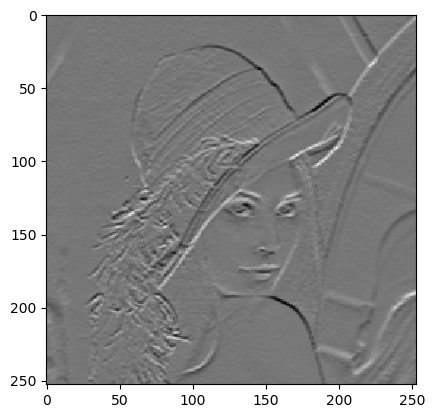

PyObject <matplotlib.image.AxesImage object at 0x13697e650>

In [127]:
PyPlot.imshow(Xconv5, cmap="gray")

### Write convolution in the code

Problem: this does not generalize to different kernel sizes

In [264]:

function convolution_2d_6(X,K)
    im_width, im_height = size(X)
    array_type = eltype(X)
    f = size(K, 1)
    output = zeros(eltype(X), im_width-f, im_height-f)
    @inbounds  for w in 1:im_width-f
        for h in 1:im_height-f            
            a = X[w,h]  * K[1] + X[w+1,h]  * K[2] + X[w+2,h]* K[3] +
                X[w,h+1]* K[4] + X[w+1,h+1]* K[5] + X[w+2,h+2]* K[6] +
                X[w,h+2]* K[7] + X[w+1,h+2]* K[8] + X[w+2,h+2]* K[9]
        end
    end
    return output
end

convolution_2d_6 (generic function with 1 method)

In [265]:
@benchmark convolution_2d_6(X,K)

BenchmarkTools.Trial: 
  memory estimate:  7.08 MiB
  allocs estimate:  448065
  --------------
  minimum time:     2.744 ms (0.00% GC)
  median time:      2.835 ms (0.00% GC)
  mean time:        3.182 ms (10.92% GC)
  maximum time:     4.738 ms (34.79% GC)
  --------------
  samples:          1571
  evals/sample:     1